In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23',)

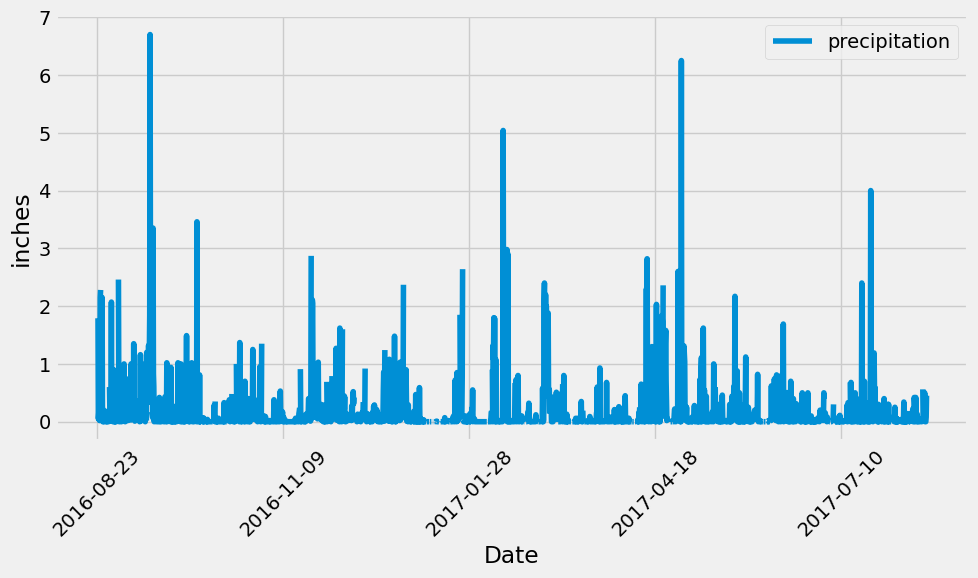

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d').date()

# Calculate the date one year from the last date in data set.
query_date = latest_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(query, columns=['date', 'precipitation'])

# Sort the dataframe by date
df.sort_values(by='date', inplace=True, ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
# Plot the data using Pandas and Matplotlib
df.plot(x='date', y='precipitation', figsize=(10, 6), rot=45)
plt.xlabel('Date')
plt.ylabel('inches')
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = pd.DataFrame(df['precipitation'].describe())
summary_stats

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.station)).all()

[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
popular_stations = session.query(Measurement.station, 
                                 func.count(Measurement.id).label('observation_count')).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.id).desc()).all()
popular_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_popular_station = popular_stations[0].station # returns 'USC00519281'

sel = [Measurement.station, 
      func.min(Measurement.tobs),
      func.max(Measurement.tobs),
      func.avg(Measurement.tobs)]
most_popular_query = session.query(*sel).filter_by(station = most_popular_station).all()
most_popular_query

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

Text(0.5, 0, 'Temperature')

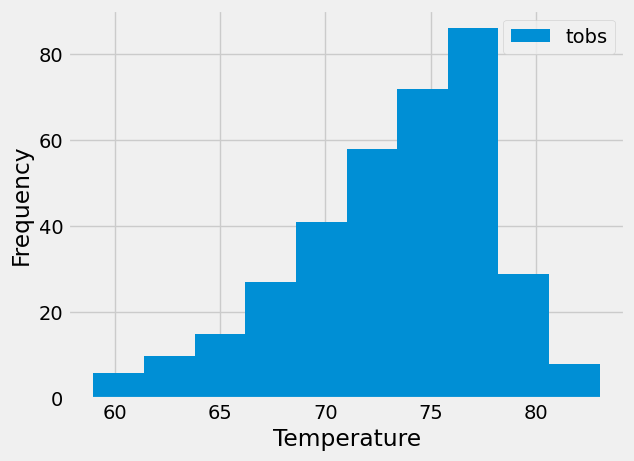

In [50]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_query = (
    session.query(Measurement.date, Measurement.tobs).
    filter(Measurement.station == most_popular_station).
    filter(Measurement.date >= query_date).all()
)

year_query_df = pd.DataFrame(year_query)

year_query_df.plot(kind='hist')
plt.xlabel('Temperature')


# Close Session

In [16]:
# Close Session
session.close()